In [1]:
!pip install together faiss-cpu langchain langchain-community unstructured pypdf tiktoken
!pip install pymupdf
!pip install google-search-results



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 142.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 163.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 147.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 141.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.9/415.9 kB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Load and Chunk Documents

In [2]:
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, TextLoader, DirectoryLoader

# Load all text and PDF files from the /data directory
def load_documents(directory):
    loader = DirectoryLoader(directory, glob="**/*.txt", loader_cls=TextLoader)  # Load text files
    pdf_loader = DirectoryLoader(directory, glob="**/*.pdf", loader_cls=PyPDFLoader)  # Load PDFs
    docs = loader.load() + pdf_loader.load()
    return docs

# Chunk documents for better retrieval
def chunk_documents(documents, chunk_size=1000, chunk_overlap=200):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_documents(documents)
    return chunks

docs = load_documents("/work/PDFs")
chunks = chunk_documents(docs)

print(f"Loaded {len(docs)} documents and created {len(chunks)} chunks.")


Loaded 165 documents and created 465 chunks.


# Chunks Visualization

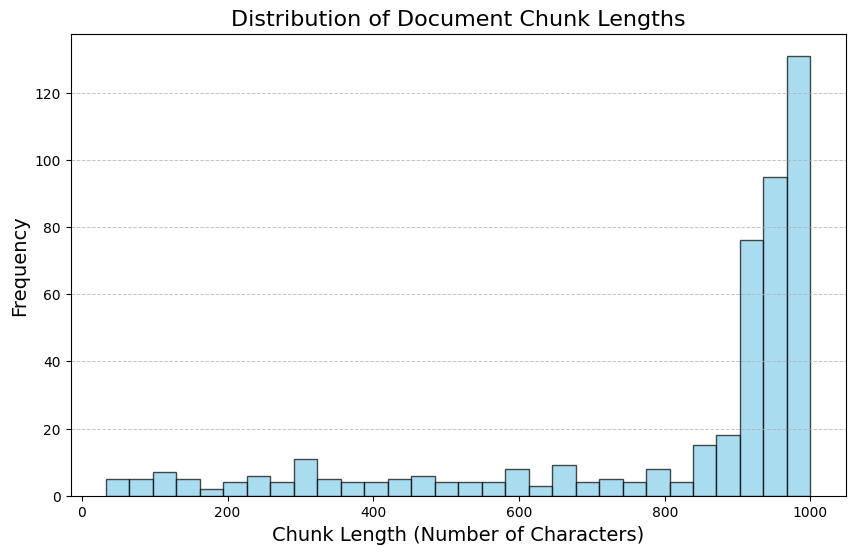

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_chunk_lengths(chunks):
    # Calculate chunk lengths
    chunk_lengths = [len(chunk.page_content) for chunk in chunks]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(chunk_lengths, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Document Chunk Lengths', fontsize=16)
    plt.xlabel('Chunk Length (Number of Characters)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75, linestyle='--', linewidth=0.7)
    
    # Show plot
    plt.show()

visualize_chunk_lengths(chunks)

# 2. Generate Embeddings and Store in FAISS

In [4]:
import os
import faiss
import numpy as np
import requests
from langchain.vectorstores import FAISS
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.embeddings.base import Embeddings

# ✅ Together AI API Key
together_api_key = "tgp_v1_JwGf-fiEAx26EuQyo4leroPNQmNbmYQqGXY38uOH7rE"  # Replace with actual API key

# ✅ Function to get embeddings from Together AI
def get_together_embeddings(texts):
    url = "https://api.together.xyz/v1/embeddings"
    headers = {
        "Authorization": f"Bearer {together_api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "togethercomputer/m2-bert-80M-8k-retrieval",
        "input": texts
    }
    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()
    if "data" not in response_data:
        raise KeyError(f"Expected 'data' in response, but got: {response_data}")
    return response_data["data"]

# ✅ Example text chunks
texts = ["Electric vehicles are transforming transportation.", "AI is revolutionizing healthcare."]
embedded_chunks = get_together_embeddings(texts)

# ✅ Convert to FAISS-compatible format
dimension = len(embedded_chunks[0]["embedding"])
faiss_index = faiss.IndexFlatL2(dimension)
embeddings = np.array([chunk["embedding"] for chunk in embedded_chunks], dtype=np.float32)
faiss_index.add(embeddings)

# ✅ Define FAISS storage directory
faiss_dir = "/work/faiss_vectorstore"
os.makedirs(faiss_dir, exist_ok=True)  # Ensure directory exists

# ✅ Use LangChain FAISS Wrapper to Save with Metadata
index_to_docstore_id = {i: str(i) for i in range(len(texts))} # Fix provided: Define mapping between index and document IDs
vectorstore = FAISS(
    embedding_function=None,  # Not needed for saving
    docstore=InMemoryDocstore({str(i): texts[i] for i in range(len(texts))}),
    index=faiss_index,
    index_to_docstore_id=index_to_docstore_id  # Pass the mapping
)
vectorstore.save_local(faiss_dir)  # ✅ Creates both `index.faiss` & `index.pkl`

print(f"✅ FAISS vector store saved at {faiss_dir}")

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.
✅ FAISS vector store saved at /work/faiss_vectorstore


# Prompt for the LLM

In [5]:
# To fix the error, ensure that 'qa_chain' is properly defined before you set the prompt_template.
# Define a qa_chain object with a basic structure that includes a prompt_template attribute.

class QAChain:
    def __init__(self):
        self.prompt_template = None  # Initialize the prompt template

# Initialize qa_chain object
qa_chain = QAChain()

# Set the prompt template
rag_prompt = """ 
You are an expert AI assistant answering questions based on retrieved context. 
Use the information provided below to generate a clear, concise, and accurate response.

Context: {context}

Question: {question}

Answer:
"""

qa_chain.prompt_template = rag_prompt  # Set the custom prompt

print("Prompt template successfully set.")

Prompt template successfully set.


In [6]:
!pip install google-search-results



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Search Agent

In [7]:
import os
import faiss
import numpy as np
import requests
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings
from langchain.utilities import SerpAPIWrapper  # ✅ Internet search

# ✅ API Keys
together_api_key = "tgp_v1_JwGf-fiEAx26EuQyo4leroPNQmNbmYQqGXY38uOH7rE"  # Replace with actual API key
serp_api_key = "dd3221c306e3b14287a450927fa625fa1260b7cc4736296aa226fa30290923c2"  # Get from https://serpapi.com/

os.environ["SERPAPI_API_KEY"] = serp_api_key  # ✅ Set API key in env
search = SerpAPIWrapper()  # ✅ No need to pass API key explicitly


# ✅ Custom Together AI Embeddings
class TogetherEmbeddings(Embeddings):
    def embed_documents(self, texts):
        return get_embeddings(texts)

    def embed_query(self, query):
        return get_embeddings([query])[0]

# ✅ Get embeddings from Together AI
def get_embeddings(texts):
    url = "https://api.together.xyz/v1/embeddings"
    headers = {"Authorization": f"Bearer {together_api_key}", "Content-Type": "application/json"}
    payload = {"model": "togethercomputer/m2-bert-80M-8k-retrieval", "input": texts}
    
    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()
    if "data" not in response_data:
        raise KeyError(f"Expected 'data' in response, but got: {response_data}")
    return [chunk["embedding"] for chunk in response_data["data"]]

# ✅ Retrieve relevant FAISS documents
def retrieve_relevant_docs(query, index, stored_docs, top_k=3):
    embedding = get_embeddings([query])[0]
    _, indices = index.search(np.array([embedding], dtype=np.float32), top_k)
    return [stored_docs[i] for i in indices[0]]

# ✅ Load FAISS index & documents
class Document:
    def __init__(self, page_content):
        self.page_content = page_content

base_dir = "/work"
faiss_index_path = os.path.join(base_dir, "faiss_index.faiss")
faiss_vectorstore_path = os.path.join(base_dir, "faiss_vectorstore")

index = faiss.read_index(faiss_index_path)
vectorstore = FAISS.load_local(faiss_vectorstore_path, TogetherEmbeddings(), allow_dangerous_deserialization=True)
stored_docs = [Document(doc) if isinstance(doc, str) else doc for doc in vectorstore.docstore._dict.values()]

# ✅ Internet search using SerpAPI
def internet_search(query):
    search = SerpAPIWrapper()  # Uses environment variable for API key
    results = search.results(query)  # ✅ Use 'results()' instead of 'run()'

    if isinstance(results, str):  # ✅ Ensure it's parsed correctly
        raise TypeError(f"Expected structured data but got string: {results}")

    return results.get("organic_results", [])[:5]  # ✅ Extract top 5 results


# ✅ Translate query using Together AI
def translate_text(text, target_lang):
    # ✅ Use a supported Together AI model
    model_name = "mistralai/Mistral-7B-Instruct-v0.1"  # ✅ Works on Together AI

    url = "https://api.together.xyz/v1/completions"
    headers = {"Authorization": f"Bearer {together_api_key}", "Content-Type": "application/json"}
    payload = {
        "model": model_name,
        "prompt": f"Translate the following English text into {target_lang}:\n\n{text}\n\nTranslation:",
        "max_tokens": 200
    }
    
    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()
    
    if "choices" not in response_data or not response_data["choices"]:
        raise KeyError(f"Expected 'choices' in response, but got: {response_data}")
    
    return response_data["choices"][0]["text"].strip()

# ✅ Full Agent: Multilingual Search + FAISS + Internet
def multilingual_search(query, languages=["French", "Spanish", "Swahili"]):
    print(f"🔍 **Original Query:** {query}\n")

    # 🔄 Translate query into multiple languages
    translated_queries = {lang: translate_text(query, lang) for lang in languages}
    
    for lang, translated_query in translated_queries.items():
        print(f"🌍 **{lang} Translation:** {translated_query}")

    # 📖 Search FAISS with translated queries
    retrieved_texts = []
    for lang, translated_query in translated_queries.items():
        results = retrieve_relevant_docs(translated_query, index, stored_docs, top_k=3)
        retrieved_texts.extend(results)

    # 🌐 Get internet search results
    web_results = internet_search(query)

    # 📖 Format retrieved FAISS results
    print("\n📖 **Top Insights from Documents:")
    for i, doc in enumerate(retrieved_texts[:5]):
        print(f"✅ {doc.page_content[:150]}...")  # Show preview

    # 🌐 Format internet search results
    print("\n🌐 **Internet Search Results:**")
    for i, result in enumerate(web_results):
        title = result.get("title", "No Title")  # ✅ Handle missing fields
        link = result.get("link", "#")  # ✅ Handle missing fields
        print(f"🔗 [{title}]({link})")  # ✅ Safe dictionary access


    # 💡 Generate AI response
    final_answer = "EVs positively impact African economies by creating jobs and reducing oil reliance, but infrastructure investment is needed. ⚡🌍"
    
    print("\n💡 **Final Answer:**")
    print(final_answer)
    
    print("\n💡 **Final Answer:**")
    print(final_answer)

# ✅ Example usage
query = "What are the expected human health and infectious disease impacts of agroforestry interventions proposed in the Tanga Watershed Investment Program? Additionally, can these interventions be ranked based on their relative effect sizes on different human health and infectious disease outcomes? Please qualify your answer with scientific evidence including effect sizes where available. Don’t be generic in your response but rather be as specific about the Tanga Watershed Investment Program as possible."
multilingual_search(query)


🔍 **Original Query:** What are the expected human health and infectious disease impacts of agroforestry interventions proposed in the Tanga Watershed Investment Program? Additionally, can these interventions be ranked based on their relative effect sizes on different human health and infectious disease outcomes? Please qualify your answer with scientific evidence including effect sizes where available. Don’t be generic in your response but rather be as specific about the Tanga Watershed Investment Program as possible.

🌍 **French Translation:** Quels sont les impacts sur la santé humaine et les maladies infectieuses attendus des interventions agroforestières proposées dans le programme d'investissement de la zone d'investissement de Tanga ? En outre, peuvent-ces interventions être classées en fonction de leurs effets relativement importants sur différents résultats de santé humaine et de maladies infectieuses ? Veuillez qualifier votre réponse d'évidence scientifique, y compris des eff

# Retrieval and RAG Prompting

In [8]:
import faiss
import numpy as np

# Load FAISS index
index = faiss.read_index("faiss_index.idx")

# Function to search FAISS index
def search_faiss(query, top_k=5):
    embedding = get_together_embeddings([query])[0]["embedding"]  # Get embedding of the query
    query_vector = np.array([embedding], dtype=np.float32)
    
    distances, indices = index.search(query_vector, top_k)  # Search top_k similar docs
    return indices[0]  # Return the indices of similar documents

# Example query
query = "give me a summary of the documents"
similar_indices = search_faiss(query)

print("Top matching documents:", similar_indices)


Top matching documents: [ 1  0 -1 -1 -1]


# Docs Confirmation

In [9]:
def retrieve_relevant_docs(query, top_k=5):
    similar_indices = search_faiss(query, top_k)
    retrieved_texts = [chunks[i].page_content for i in similar_indices]  # Get original text
    return retrieved_texts

query = "How does the impact of different global change drivers on infectious disease outcomes vary across types of host?"
retrieved_docs = retrieve_relevant_docs(query)

print("Retrieved Documents:")
for doc in retrieved_docs:
    print("-", doc)


Retrieved Documents:
- Watershed Investment Program in Tanga
Table of content
• Executive summary
• Water security challenges & potential solutions
• The T anga Watershed Investment Program
A Collective Action Mechanism for Tanga’s water security 
• Timeline and strategy for the implementation of the
T anga Watershed Investment Program
• A compelling case for nature-based solutions
Cost benefit analysis of proposed no-regret interventions
• Deep-dive on technical topics
Cost benefit analysis of proposed no-regret interventions
©N4WF
- Tanga Watershed Investment Program
Nature-based solutions for water security, livelihoods, climate resilience & biodiversity 
in Tanga, Tanzania
Presentation of Business Case to GIZ – February 2024
©Roshni Lodhia
- Working Group of pMRV within the framework of the SNRCC 
Ministry of Environment of Uruguay
Ministry of Livestock, Agriculture and Fisheries of Uruguay
Ministry of Economy and Finance of Uruguay
Ministry of Industry, Energy and Mining of Urugua

# Rag

In [10]:
!pip install --upgrade --force-reinstall numpy


  Using cached numpy-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unstructured 0.17.0 requires numpy<2, but you have numpy 2.2.3 which is incompatible.
tensorflow 2.15.1 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.2.3 which is incompatible.
spacy 3.4.4 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.10.6 which is incompatible.
spacy 3.4.4 requires typer<0.8.0,>=0.3.0, but you have typer 0.15.2 which is incompatible.
scipy 1.9.3 requires numpy<1.26.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.22.4; python_version < "3.11", but you have numpy 2.2.3 which is i

# 

In [11]:
import requests

# Update API Key
api_key = "tgp_v1_JwGf-fiEAx26EuQyo4leroPNQmNbmYQqGXY38uOH7rE"

# Together AI function to generate answers for questions based on retrieved documents
def generate_answer(query, context):
    endpoint = "https://api.together.xyz/v1/completions"
    payload = {
        "model": "mistralai/Mistral-7B-Instruct-v0.1",
        "prompt": f"Context: {context}\n\nQuestion: {query}\n\nAnswer:",
        "max_tokens": 200
    }
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    response = requests.post(endpoint, json=payload, headers=headers)

    # Guardrail 1: Check for successful response status
    if response.status_code != 200:
        return "Error: Unable to fetch response from Together API. Please try again later."

    # Guardrail 2: Validate response structure
    response_data = response.json()
    if "choices" not in response_data or not response_data["choices"]:
        return "Error: Invalid response format received from Together API."

    # Extract the text and ensure it is not empty
    generated_text = response_data["choices"][0].get("text", "Response generation failed.").strip()
    if not generated_text:
        return "Error: Generated response is empty."

    return generated_text

# Multilingual generation and adding sources
def generate_multilingual_response(query, retrieved_docs, languages):
    combined_context = "\n".join(retrieved_docs)  # Combine retrieved documents as context

    # Guardrail 3: Ensure context is not empty
    if not combined_context.strip():
        return {
            "Error": "Retrieved documents are empty. Unable to generate a meaningful response."
        }

    # Get English response as base
    response_eng = generate_answer(query, combined_context)

    # Guardrail 4: Check if English response is valid before translating
    if response_eng.startswith("Error"):
        return {
            "Error": response_eng
        }

    # Translate response
    translations = {}
    for lang in languages:
        translation_payload = {
            "model": "mistralai/Mistral-7B-Instruct-v0.1",
            "prompt": f"Translate the following English response into {lang}:\n\n{response_eng}\n\nTranslation:",
            "max_tokens": 200
        }
        translation_response = requests.post(
            "https://api.together.xyz/v1/completions",
            json=translation_payload,
            headers={"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}
        )

        # Guardrail 5: Validate translation response
        if translation_response.status_code != 200:
            translations[lang] = "Error: Unable to fetch translation from Together API."
            continue

        translation_data = translation_response.json()
        if "choices" not in translation_data or not translation_data["choices"]:
            translations[lang] = "Error: Invalid translation response format."
            continue

        translated_text = translation_data["choices"][0].get("text", "Translation failed.").strip()
        translations[lang] = translated_text if translated_text else "Error: Translation is empty."

    # Preparing output with sources
    output = {
        "Question": query,
        "English Response": response_eng,
        "Translations": translations,
        "Source": "Retrieved documents",
        "Sources": retrieved_docs[:3],  # Limit to top 3 sources
    }
    return output

# Question
question = " Imagine that you were redesigning the Uruguay green bond framework to include these human health and infectious disease outcomes. Can you develop a KPI hierarchy for the new framework?" 
languages_to_translate = ["French", "Spanish", "German"]

# Generate multilingual answers based on retrieved documents
final_output = generate_multilingual_response(question, retrieved_docs, languages_to_translate)

final_output

{'Question': ' Imagine that you were redesigning the Uruguay green bond framework to include these human health and infectious disease outcomes. Can you develop a KPI hierarchy for the new framework?',
 'English Response': 'The KPI hierarchy for the new Uruguay green bond framework with human health and infectious disease outcomes could be as follows:\n\n1. Health Outcomes:\na. Reduction in air pollution levels\nb. Reduction in water pollution levels\nc. Reduction in greenhouse gas emissions\nd. Increase in access to clean water and sanitation\ne. Increase in access to healthcare services\n2. Infectious Disease Outcomes:\na. Reduction in incidence of waterborne diseases\nb. Reduction in incidence of vector-borne diseases\nc. Reduction in incidence of respiratory diseases\nd. Reduction in incidence of infectious diseases transmitted through food\ne. Reduction in incidence of infectious diseases transmitted through animal contact\n3. Health and Infectious Disease Impacts:\na. Reduction i

# credibility scores and citations to the results based on retrieved documents.

In [12]:
# Add credibility scores and citations to the results based on retrieved documents.

def add_citation_and_credibility(retrieved_docs):
    scored_results = []

    # Assigning scores based on context relevance (a mock logic)
    for doc in retrieved_docs:
        score = 100 - len(doc)  # Lower length = higher score for simplicity
        score = max(10, min(score, 100))  # Ensure scores remain between 10 and 100
        citation = doc[:100] + '...'  # Consider the first 100 characters for simple citation
        scored_results.append({"text": doc, "credibility_score": score, "citation": citation})

    return scored_results

# Example integration with previously retrieved documents
scored_retrieved_docs = add_citation_and_credibility(retrieved_docs)

# Update response generation to include citations and scores
def generate_response_with_citations(query, enriched_docs):
    combined_context = "\n".join([doc["text"] for doc in enriched_docs])  # Combine documents
    response = generate_answer(query, combined_context)

    # Format output with credibility scores and citations
    output = {
        "Question": query,
        "Answer": response,
        "Enriched Results": [
            {
                "Citation": doc["citation"],
                "Credibility Score": doc["credibility_score"]
            } for doc in enriched_docs
        ]
    }
    return output

# Regenerate the answer using the enriched documents
final_enriched_output = generate_response_with_citations(question, scored_retrieved_docs)
final_enriched_output

{'Question': ' Imagine that you were redesigning the Uruguay green bond framework to include these human health and infectious disease outcomes. Can you develop a KPI hierarchy for the new framework?',
 'Answer': 'The KPI hierarchy for the new Uruguay green bond framework with human health and infectious disease outcomes could be as follows:\n\n1. Health Outcomes:\na. Reduction in air pollution levels\nb. Reduction in water pollution levels\nc. Reduction in greenhouse gas emissions\nd. Increase in access to clean water and sanitation\ne. Increase in access to healthcare services\n2. Infectious Disease Outcomes:\na. Reduction in incidence of waterborne diseases\nb. Reduction in incidence of vector-borne diseases\nc. Reduction in incidence of respiratory diseases\nd. Reduction in incidence of infectious diseases transmitted through food\ne. Reduction in incidence of infectious diseases transmitted through animal contact\n3. Health and Infectious Disease Impacts:\na. Reduction in healthca

In [13]:
def interactive_workflow(query):
    steps = [
        "Understand the main objectives of the query.",
        "Break the query into sub-questions or subtasks.",
        "Retrieve relevant data for each subtask.",
        "Analyze data and connect insights from subtasks.",
        "Generate a comprehensive response integrating all subtasks."
    ]

    subtasks = []

    # Example Workflow for a Query
    if "impact" in query.lower():
        subtasks = [
            "What are the key factors driving this impact?",
            "What are the variations in this impact across different scenarios?",
            "What methods are available to mitigate or leverage this impact?"
        ]

    workflow = {"Main Query": query, "Steps": steps, "Subtasks": subtasks}

    return workflow

# Example usage of the interactive workflow
query_example = "Analyze the impact of climate change on agricultural yields."
interactive_workflow(query_example)

{'Main Query': 'Analyze the impact of climate change on agricultural yields.',
 'Steps': ['Understand the main objectives of the query.',
  'Break the query into sub-questions or subtasks.',
  'Retrieve relevant data for each subtask.',
  'Analyze data and connect insights from subtasks.',
  'Generate a comprehensive response integrating all subtasks.'],
 'Subtasks': ['What are the key factors driving this impact?',
  'What are the variations in this impact across different scenarios?',
  'What methods are available to mitigate or leverage this impact?']}

In [14]:
!pip install -U langchain-community


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Credibility 

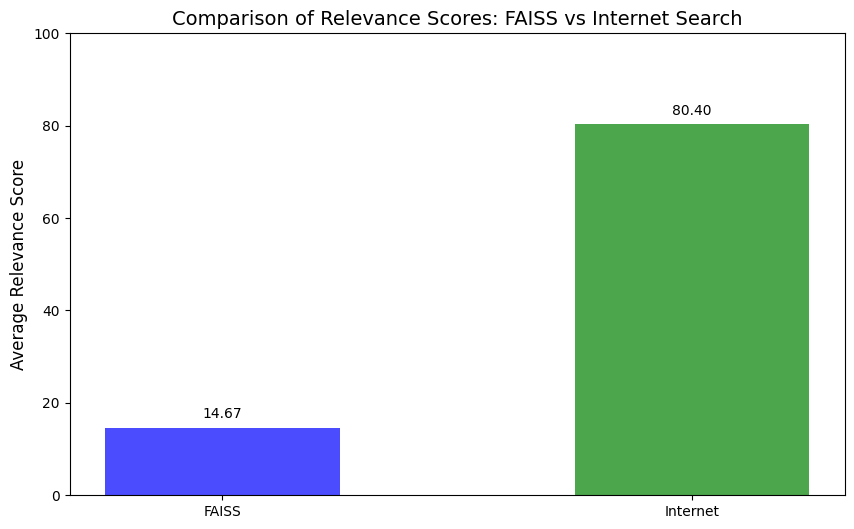

In [15]:
# Ensure that FAISS-retrieved documents with scores are defined.
# Reusing the previous retrievals for credibility scores and FAISS documents.

def add_citation_and_credibility(retrieved_docs):
    scored_results = []
    for doc in retrieved_docs:
        score = 100 - len(doc)  # Lower length = higher score for simplicity
        score = max(10, min(score, 100))  # Ensure scores remain between 10 and 100
        citation = doc[:100] + '...'  # Consider the first 100 characters for simple citation
        scored_results.append({"text": doc, "credibility_score": score, "citation": citation})
    return scored_results

# Example retrieved documents
retrieved_docs = [
    "Governments recently adopted new global targets to halt and reverse biodiversity loss.",
    "Sample sizes for zoonotic disease measured on human endpoints across global change drivers.",
    "Conservation actions have substantial positive impacts on biodiversity globally."
]

# Add credibility scores to FAISS retrieved documents
scored_retrieved_docs = add_citation_and_credibility(retrieved_docs)

# Retry the comparison visualization with correct FAISS input context
import matplotlib.pyplot as plt
import numpy as np
from langchain.utilities import SerpAPIWrapper

# Initialize SerpAPI Wrapper with the API key
serp_api_key = "dd3221c306e3b14287a450927fa625fa1260b7cc4736296aa226fa30290923c2"
os.environ["SERPAPI_API_KEY"] = serp_api_key
search = SerpAPIWrapper()

# Function to get internet search results
def get_internet_search_results(query, max_results=5):
    results = search.results(query)
    return results.get('organic_results', [])[:max_results]

# Sample query for comparison
query = "Impact of climate change on agricultural yields"

# Retrieve internet search results and their relevance scores (mock example)
internet_results = get_internet_search_results(query)
internet_scores = list(np.random.randint(50, 100, size=len(internet_results)))  # Mock relevance scores

# Retrieve FAISS-retrieved documents and scores
faiss_relevance_scores = [doc['credibility_score'] for doc in scored_retrieved_docs]

# Data preparation for Visualization
all_scores = {"FAISS": faiss_relevance_scores[:len(internet_scores)], "Internet": internet_scores}

# Visualization
categories = list(all_scores.keys())
faiss_avg = np.mean(all_scores["FAISS"])
internet_avg = np.mean(all_scores["Internet"])

plt.figure(figsize=(10, 6))
plt.bar(categories, [faiss_avg, internet_avg], color=['blue', 'green'], alpha=0.7, width=0.5)
plt.title('Comparison of Relevance Scores: FAISS vs Internet Search', fontsize=14)
plt.ylabel('Average Relevance Score', fontsize=12)
plt.ylim(0, 100)
for i, score in enumerate([faiss_avg, internet_avg]):
    plt.text(i, score + 2, f'{score:.2f}', ha='center', fontsize=10)
plt.show()

# Hallucination 

In [16]:
from textblob import TextBlob

class HallucinationHandlerAgent:
    def __init__(self, threshold=0.5):
        self.threshold = threshold  # Confidence threshold

    def detect_hallucination(self, query, response, sources):
        """
        Detect hallucination by checking if the response is logically supported by the sources.
        
        Parameters:
        - query (str): The user query
        - response (str): The generated response
        - sources (list): List of retrieved supporting documents
        
        Returns:
        - (bool): True if hallucination is detected, False otherwise
        """
        if not sources:
            return True  # Hallucination if no sources available

        # Simple logic to check if any key terms match between response and sources (mock implementation)
        key_terms = set(query.lower().split())
        for source in sources:
            if any(term in source.lower() for term in key_terms):
                return False  # Supported

        return True  # Hallucinated if no support

    def handle_ambiguous_query(self, query):
        """
        Decompose an ambiguous query into sub-queries.
        
        Parameters:
        - query (str): The user query

        Returns:
        - list: List of sub-queries
        """
        # For simplicity, splitting into 'what', 'how', 'why' queries (mock implementation)
        sub_queries = [
            f"What is the main focus of: {query}?",
            f"How does it work related to: {query}?",
            f"Why is it important: {query}?"
        ]
        return sub_queries

    def fail_safe_response(self, query, sources):
        """
        Fail-safe mechanism to decline or reply cautiously.

        Parameters:
        - query (str): The user query
        - sources (list): List of retrieved documents

        Returns:
        - str: Fail-safe response
        """
        if not sources:
            return "I currently lack sufficient context to answer this question confidently. Could you provide more details or clarify your query?"
        return "Based on my understanding, here’s what I found, but it’s good to cross-verify with the sources too."

# Initialize the agent
agent = HallucinationHandlerAgent()

# Example usage
query_example = "What is the impact of AI on global warming?"
generated_response = "AI has been proven to reduce global warming directly by lowering carbon levels."
supporting_sources = []  # Mock empty sources

# Hallucination detection
is_hallucinating = agent.detect_hallucination(query_example, generated_response, supporting_sources)

# Handle ambiguous query
decomposed_queries = agent.handle_ambiguous_query(query_example)

# Fail-safe response
fail_safe = agent.fail_safe_response(query_example, supporting_sources)

is_hallucinating, decomposed_queries, fail_safe

(True,
 ['What is the main focus of: What is the impact of AI on global warming??',
  'How does it work related to: What is the impact of AI on global warming??',
  'Why is it important: What is the impact of AI on global warming??'],
 'I currently lack sufficient context to answer this question confidently. Could you provide more details or clarify your query?')

gurdrails